# **Análisis Cluster**
El análisis cluster, o análisis de conglomerados, es una técnica estadística multivariante, cuyo objetivo es agrupar los elementos o variables análizadas en distintos grupos (clusters) en función de la homogeneidad existente entre ellas. 

El análisis cluster engloba distintos métodos, en nuestro ejemplo nos centraremos en el método K-means. El método **K-means** agrupa los elementos o variables analizadas en un número de clusters ya predeterminado. 

Para llevar a cabo nuestro ejemplo, escogeremos el dataset **ecv_cluster**, elaborado a partir de los datos publicados por el INE. 

## **K-means**

###**Carga de librerias y datos**
Cargamos las librerias que vamos a utilizar en el modelo.

In [31]:
# Preparación de los datos 
import numpy as np
import pandas as pd
# Modelado 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
# Visualización
import matplotlib.pyplot as plt


Subimos a Colab el archivo que vamos a utilizar, en nuestro caso es **ecv_cluster** 

In [32]:
from google.colab import files
uploaded = files.upload()

Saving ecv_cluster.xlsx to ecv_cluster (3).xlsx


Visualizamos los datos del archivo que acabamos de cargar.

In [33]:
datos=pd.read_excel('ecv_cluster.xlsx')
datos.head()

,ccaa,taspobex,taspob,tascar,tasvivtrab
0,Andalucía,35.1,28.5,8.0,13.5
1,Aragón,18.5,16.0,1.7,6.1
2,"Asturias, Principado de",27.7,22.2,4.5,17.8
3,"Balears, Illes",22.0,14.1,6.9,4.5
4,Canarias,36.3,29.9,10.7,15.3


Creamos las diferentes variables que vamos a utilizar. En este caso, en la variable columnas, seleccionaremos la tasa de riesgo de pobreza o exclusión social (indicador AROPE) y la tasa de carencia material severa. Después, la lista que acabamos de crear, la convertimos en un DataFrame (resultado). Además, también tenemos nuestra serie con las comunidades autónomas.

In [34]:
columnas = ["taspobex", "tascar"]
resultado = datos[columnas]
comunidades = datos["ccaa"]


###**Método Elbow**
Para ver el número de cluster adecuado, aplicaremos el **método Elbow** o método del codo, en el cual medimos la distancia promedia de todos los puntos del cluster y su centroide, a través de la suma de sus cuadrados, con el objetivo de minimizar la varianza intra-cluster y maximizar de la varianza inter-cluster. 

Para calcularlo matemáticamente, nos situamos en el gráfico, donde tenemos en el eje x el número de cluster utilizados y en el eje y la suma de los cuadrados intra-cluster (dentro del cluster). Trazamos una línea entre los puntos calculados entre el primer y el último cluster, ese punto óptimo, en el que hay una mayor homogeneidad dentro del cluster y una mayor diferencia entre los cluster, es el punto más distante con la línea trazada. Dado que tenemos 19 variables, creemos conveniente encoger que los cluster se sitúen entre 1 y 10, ya que el punto más alejado se encontrará ahí, en 19 la distancia es 0. 

Para calcular la distancia de cada punto a la línea trazada se utiliza la siguiente fórmula:  

$$D[(P_0,P_1),(x,y)] = \frac{|(y_1-y_0)x-(x_1-x_0)y+x_1y_o-y_1x_0|}{\sqrt{(y_1-y_0)^2+(x_1-x_0)^2}}$$  

Para calcularlo en nuestro código, utilizaremos nuestra lista inercia[ ],que contiene la suma de cuadrados dentro de los cluster y nos delvolverá el número optimo de cluster.


El número óptimo de clusters es:  4 



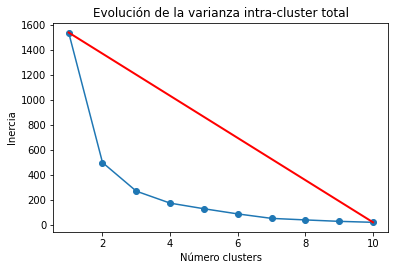

In [35]:
range_clusters = range(1, 11)
inercia = []

for i in range_clusters:
    modelo = KMeans(
                        n_clusters   = i, 
                        n_init       = 20, 
                        random_state = 50
                     )
    modelo.fit(resultado)
    inercia.append(modelo.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_clusters, inercia, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Inercia')

# Trazamos la línea
x0, y0 = 1, inercia[0]
x1, y1 = 10, inercia[len(inercia)-1]
ax.plot([x0, x1], [y0, y1], color='red', linewidth=2)

# Determinamos las distancias desde cada punto x, y a la recta P_0-P_1
distancias = []
for i in range(len(inercia)):
  x = i+2
  y = inercia[i]
  numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
  denominador = np.sqrt((y1 - y0)**2 + (x1 - x0)**2)
  distancias.append(numerador/denominador)
print('\nEl número óptimo de clusters es: ', distancias.index(max(distancias)) + 2, '\n')

Ahora, creamos los **cluster**. En primer lugar, vamos a escalar el modelo, para que los datos se situen dentro de un mismo rango, para ello usamos scale ( ).Además, utilizamos fit( ) para ajustar el modelo a los datos que hemos cargado y el método predict( ) para realizar predicciones. 

In [36]:
resultado_escalado = scale(resultado)
modelo = KMeans(n_clusters=4)
modelo.fit(resultado_escalado)
grupos = modelo.predict(resultado_escalado)

Una vez creados los cluster, los relacionamos con nuestra variable comunidades que contiene las Comunidades Autonomas. 

In [37]:
clusters=pd.concat([comunidades,pd.DataFrame(grupos)],axis=1)
clusters.rename(columns={"ccaa":"Comunidades Autónomas",0:"Cluster"},inplace=True)
clusters

,Comunidades Autónomas,Cluster
0,Andalucía,1
1,Aragón,0
2,"Asturias, Principado de",3
3,"Balears, Illes",3
4,Canarias,2
5,Cantabria,3
6,Castilla y León,0
7,Castilla - La Mancha,3
8,Cataluña,3
9,Comunitat Valenciana,2


###**Representación gráfica**
Vamos a visualizar nuestro modelo, para ello, definimos la función que vamos a llevar a cabo, en este caso situación. En nuestro gráfico de dispersión tendremos dos parametros, x e y, que serán los datos escogidos, c que es el color que le vamos a dar a los datos y s el tamaño de la forma en la que se presenta el dato (marker). 

Además, introducimos unos centroides que se situaran en el centro de cada cluster. 

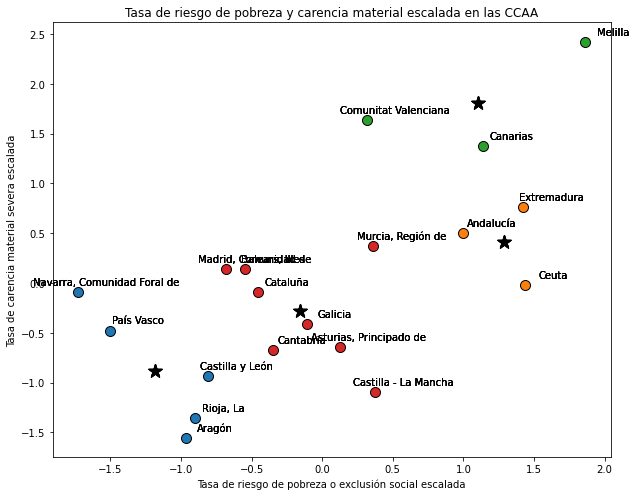

In [38]:
def situacion (x, y, z):
  fig, ax = plt.subplots()
  for i in np.unique(grupos):
    ax.scatter(
        x = resultado_escalado[grupos == i, 0],
        y = resultado_escalado[grupos == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        s=100,
        marker    = 'o',
        edgecolor = 'black', 
        label= f'Cluster {i}'
    )
    for i in range(19):       
       ax.text(x[i]+0.2,y[i]+0.1, z[i], color = 'black', ha = 'center', va = 'center')
    ax.set_title('Tasa de riesgo de pobreza y carencia material escalada en las CCAA')
    ax.set_xlabel('Tasa de riesgo de pobreza o exclusión social escalada')
    ax.set_ylabel('Tasa de carencia material severa escalada')
    ax.scatter(
    x = modelo.cluster_centers_[:,0],
    y = modelo.cluster_centers_[:,1], 
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
  )
  fig.set_figheight(8)
  fig.set_figwidth(10)
  fig.show()
ax.set_title('Clusters generados por Kmeans')
situacion(resultado_escalado[:,0],resultado_escalado[:,1],comunidades)

Podemos concluir que los 4 clusters presentan diferencias notables. El cluster verde representa a las comunidades que tienen una menor tasa de carencia material y de riesgo de pobreza, a pesar de que hay comunidades que presentan una tasa de carencia menor, como Castilla-La Mancha, presenta una tasa de riesgo de pobreza mayor, lo que le hace irse a al cluster azul. El cluster de color rojo representa a las comunidades con una gran tasa de pobreza. Y, por último, el cluster naranja representa a las comunidades con elevadas tasas en ambas variables.